# Spaceship Titanic 🚀

<div align="center">
    <img src='https://pic2.zhimg.com/v2-768b110090ef51c582c2f846adcb689a_r.jpg?source=172ae18b' style='height:100px;'>
</div>


>## >>>Se busca realizar la prediccion de cuantos pasajeros fueron transportados a otra dimension cuando la nave accidentalmente ingreso a la anomalia espacio-temporal.<<<

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#import missingno as msno
sns.set_context('talk')
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    plot_confusion_matrix,
    classification_report,
)
from sklearn.model_selection import (
    train_test_split,
    ParameterSampler,
    RandomizedSearchCV,
    ParameterGrid,
    GridSearchCV,
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import StandardScaler

 ### Aparentemente todas columnas parecen ser utiles para la prediccion

#### Carga de datos de train, test y submmitions.

In [2]:
train_url = "../Práctico/train.csv"
train = pd.read_csv(train_url)
print(train.shape)
train.head()

(7823, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
1,669,Mars,True,F/126/S,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1
2,8430,Europa,True,B/343/S,TRAPPIST-1e,33.0,NaN,0.0,0.0,0.0,0.0,0.0,Shaiam Tinganking,1
3,6463,Earth,False,F/1420/P,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,Landa Grifford,0
4,85,Earth,False,G/9/P,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,Gracy Dunnisey,0


In [3]:
test_url = "../Práctico/test.csv"
test = pd.read_csv(test_url)
print(test.shape)
test.head()

(870, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,415,Europa,True,NaN,55 Cancri e,34.0,False,0.0,0.0,0.0,0.0,0.0,Minopus Taptiritty
1,8663,Earth,True,G/1489/S,PSO J318.5-22,13.0,False,0.0,0.0,0.0,0.0,0.0,Chrisa Francock
2,4524,Earth,False,G/776/P,TRAPPIST-1e,44.0,False,22.0,1.0,0.0,864.0,0.0,Elinda Miley
3,8246,Earth,False,E/577/S,PSO J318.5-22,63.0,False,0.0,0.0,80.0,0.0,2322.0,Karley Goods
4,2935,Europa,False,B/117/S,55 Cancri e,10.0,False,0.0,0.0,0.0,0.0,0.0,Arkard Sechausive


In [4]:
target_url = "../Práctico/sample_submission.csv"
target = pd.read_csv(target_url)
print(target.shape)
target.head()

(870, 2)


,PassengerId,Transported
0,415,1
1,8663,1
2,4524,0
3,8246,0
4,2935,0


In [5]:
train.Transported.value_counts()

1    3964
0    3859
Name: Transported, dtype: int64

In [6]:
target.Transported.value_counts()

0    460
1    410
Name: Transported, dtype: int64

------

**El target esta balanceado y no presenta valores nulos.**

_________________________________________________________

## Analisis de correlacion de las variables de 'train'.

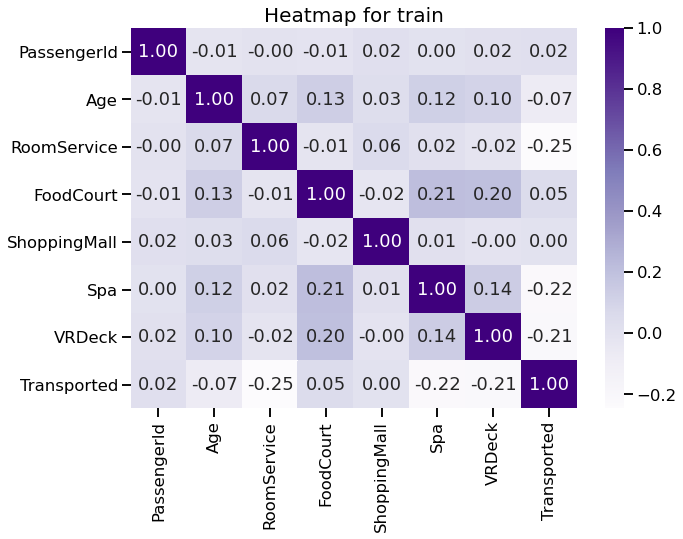

In [7]:
plt.rcParams['figure.figsize'] = (10, 7)
sns.heatmap(train.corr(), annot = True, fmt = ".2f", cmap = 'Purples')
plt.title('Heatmap for train', fontsize = 20)
plt.show()

>**Se observan ciertas correlaciones aunque nada demasiado significativo, un maximo de -0.25.**

## Observamos nulos y su porcentaje dentro de cada columna asi como en el total.

In [8]:
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, round(percent,3)], axis = 1, keys = ['Total_nuls_train', 'Percent'])
missing_data.style.background_gradient(subset = ["Percent"])

,Total_nuls_train,Percent
CryoSleep,196,0.025000
ShoppingMall,188,0.024000
Cabin,184,0.024000
VIP,184,0.024000
Name,184,0.024000
HomePlanet,179,0.023000
VRDeck,169,0.022000
Age,162,0.021000
Destination,160,0.020000
Spa,158,0.020000


In [9]:
total_nuls = missing_data.Total_nuls_train.sum()
perc_nuls = (total_nuls * 100)/len(train)
print(' Total de nulos en train: ',total_nuls,'\n Porcentaje de nulos en train: ',round(perc_nuls,2))

 Total de nulos en train:  2073 
 Porcentaje de nulos en train:  26.5


>**Basandonos en que el numero de datos nulos total representa un 26.5% del total d datos de train, es posible que tengamos que imputar datos.** 

## Analisis exploratorio de variables de 'train'.

In [10]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [11]:
train.dtypes

PassengerId       int64
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported       int64
dtype: object

In [12]:
plt.rcParams['figure.figsize'] = (7, 5)

In [13]:
#Homeplanet
#sns.histplot(data = train, x='HomePlanet',hue='Transported',palette='ocean');

In [14]:
#Destination
#sns.histplot(data = train, x='Destination',hue='Transported',palette='ocean');

In [15]:
#Age
#sns.histplot(data = train, x='Age',hue='Transported',palette='ocean');

In [16]:
#Cabin
train.Cabin.value_counts()

G/734/S     8
F/1194/P    7
E/13/S      7
B/201/P     7
C/21/P      6
           ..
D/19/P      1
C/174/P     1
E/320/P     1
F/669/P     1
G/934/S     1
Name: Cabin, Length: 6009, dtype: int64

## Analisis descriptivo de variables que no seran graficadas.  
> Las variables **CryoSleep** y **VIP** son de tipo booleano.  
> La variable **Cabin** representa el numero de cabina con el detalle de si es en babor(P) o estribor(S).  
> La variable **Name** representa el nombre completo del pasajero.  
> La variable **PassengerId** representa el id del pasajero.  

**Analisis de variables referidas al monto que el pasajero ha facturado en cada uno de los muchos servicios de lujo del Spaceship Titanic.**

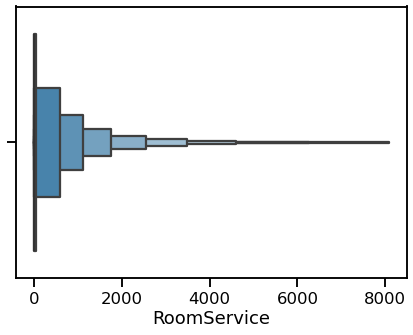

In [17]:
sns.boxenplot(train.RoomService,showfliers=False);

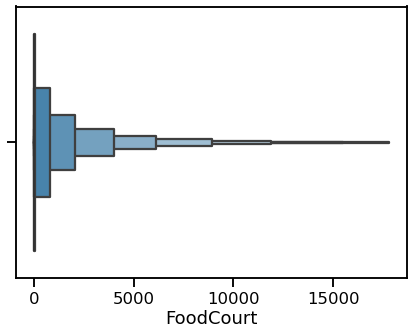

In [18]:
sns.boxenplot(train.FoodCourt,showfliers=False);

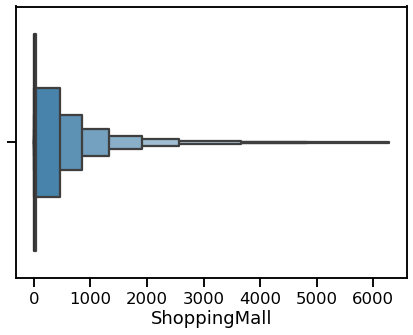

In [19]:
sns.boxenplot(train.ShoppingMall,showfliers=False);

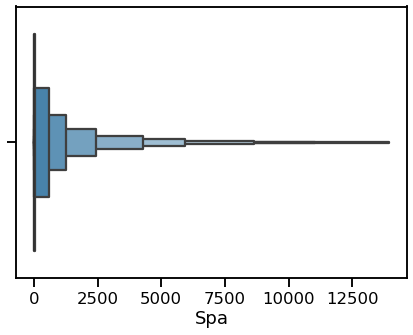

In [20]:
sns.boxenplot(train.Spa,showfliers=False);

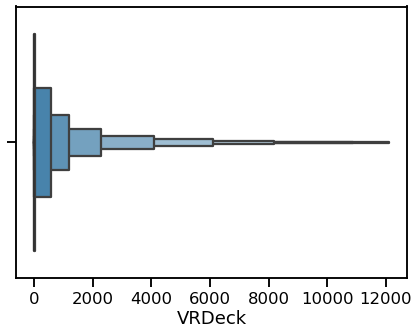

In [21]:
sns.boxenplot(train.VRDeck ,showfliers=False);

## Algunas conclusiones

>*A partir de las observaciones realizadas sobre los datos, podemos decir que las variables correspondientes al grupo de Servicios de lujo del Spaceship Titanic, contiene datos un poco desbalanceados con Outliers.  
>*A demas las variables **CryoSleep** y **VIP** son del tipo booleano, por lo cual probablemente deban descartarse o ser reemplazadas por valores numericos como 0 y 1.  
>*Las columnas categoricas Homeplanet y Destination aportan una posible clasificacion del target.  


## Posibles acciones

>*Usar metodo de imputacion de valores faltantes a los nulos de cada variable.  
>*Probar una limpieza de outliers de las columnas de montos en lujos.  
>*encodear las variables categoricas.  
>*Con respecto a las dos variables tipo boolean, ver si combiene encodearlas o modificarlas por transformarlas en 0 y 1.  
>*elegir columnas a excluir como por Name.  

__________

#### Breve analisis de nulos en 'Test'.

In [22]:
total = test.isnull().sum().sort_values(ascending = False)
percent = (test.isnull().sum() / test.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, round(percent,3)], axis = 1, keys = ['Total_nulls_test', 'Percent'])
missing_data.style.bar(subset = ["Percent"], 
             color = "lightblue", 
             vmin = 0)

,Total_nulls_test,Percent
FoodCourt,28,0.032000
RoomService,27,0.031000
Spa,25,0.029000
HomePlanet,22,0.025000
Destination,22,0.025000
CryoSleep,21,0.024000
ShoppingMall,20,0.023000
VIP,19,0.022000
VRDeck,19,0.022000
Age,17,0.020000


In [23]:
total_nuls = missing_data.Total_nulls_test.sum()
perc_nuls = (total_nuls * 100)/len(test)
print(' Total de nulos en test: ',total_nuls,'\n Porcentaje de nulos en test: ',round(perc_nuls,2))

 Total de nulos en test:  251 
 Porcentaje de nulos en test:  28.85


____________

### Columnas elegidas para el analisis en 'Train'.

Columnas elegidas: 
    

In [24]:
['HomePlanet','CryoSleep','Destination','Age','VIP','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Cabin']

['HomePlanet',
 'CryoSleep',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Cabin']

Columnas eliminadas debido a que contienen datos que son unicos o keys.

In [25]:
train = train.drop(columns = ['Name','PassengerId'])

In [26]:
train.shape

(7823, 12)

In [27]:
train_whitout_nuls = train

### Tratamiento de la variable 'Cabin' y generacion de nuevas features en 'Train'.

In [28]:
train['Cabin']

0        C/123/P
1        F/126/S
2        B/343/S
3       F/1420/P
4          G/9/P
          ...   
7818    F/1319/S
7819     G/459/S
7820    F/1772/P
7821     E/253/P
7822     B/270/P
Name: Cabin, Length: 7823, dtype: object

In [29]:
new_features = train['Cabin'].str.split(pat="/",expand=True)

In [30]:
new_features = new_features.rename(columns={0:'Deck_of_spaceship',1:'Number_of_cabin',2:'Port_or_Starboard'})
new_features.head()

,Deck_of_spaceship,Number_of_cabin,Port_or_Starboard
0,C,123,P
1,F,126,S
2,B,343,S
3,F,1420,P
4,G,9,P


In [31]:
new_features.Deck_of_spaceship.value_counts()

F    2499
G    2294
E     792
B     698
C     680
D     435
A     237
T       4
Name: Deck_of_spaceship, dtype: int64

In [32]:
#Eliminamos la columna 'Cabin' ya que las nuevas features aportan informacion con mas peso.
train = train.drop(columns='Cabin')

In [33]:
train = train.join(new_features, lsuffix='_caller', rsuffix='_other')
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck_of_spaceship,Number_of_cabin,Port_or_Starboard
0,Europa,False,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,0,C,123,P
1,Mars,True,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,1,F,126,S
2,Europa,True,TRAPPIST-1e,33.0,NaN,0.0,0.0,0.0,0.0,0.0,1,B,343,S
3,Earth,False,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,0,F,1420,P
4,Earth,False,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,0,G,9,P


Nuevas features Agregadas:  
>Deck_of_spaceship : Cubierta  
>Number_of_cabin   : Numero de Cabina  
>Port_or_Starboard : S=Babor, P=Estribor  


_________

# Imputacion de valores nulos en 'Train' para las columnas numericas.

In [34]:
train_whitout_nuls = train

In [35]:
total = train_whitout_nuls.isnull().sum().sort_values(ascending = False)
percent = (train_whitout_nuls.isnull().sum() / train_whitout_nuls.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, round(percent,3)], axis = 1, keys = ['Total_nulls_test', 'Percent'])
missing_data.style.bar(subset = ["Percent"], 
             color = "lightblue", 
             vmin = 0)

,Total_nulls_test,Percent
CryoSleep,196,0.025000
ShoppingMall,188,0.024000
VIP,184,0.024000
Deck_of_spaceship,184,0.024000
Number_of_cabin,184,0.024000
Port_or_Starboard,184,0.024000
HomePlanet,179,0.023000
VRDeck,169,0.022000
Age,162,0.021000
Destination,160,0.020000


In [36]:
train_whitout_nuls.dtypes

HomePlanet            object
CryoSleep             object
Destination           object
Age                  float64
VIP                   object
RoomService          float64
FoodCourt            float64
ShoppingMall         float64
Spa                  float64
VRDeck               float64
Transported            int64
Deck_of_spaceship     object
Number_of_cabin       object
Port_or_Starboard     object
dtype: object

In [37]:
cat_cols = ['HomePlanet','CryoSleep','Destination','VIP','Deck_of_spaceship','Port_or_Starboard']
num_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Number_of_cabin']

### Utilizando IterativeImputer imputamos valores faltantes de las columnas numericas de 'Train'.

In [38]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

In [39]:
mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())

train_whitout_nuls["Age"] = StandardScaler().fit_transform(
    train_whitout_nuls[["Age"]]
)
train_whitout_nuls["FoodCourt"] = StandardScaler().fit_transform(
    train_whitout_nuls[["FoodCourt"]]
)
train_whitout_nuls["RoomService"] = StandardScaler().fit_transform(
    train_whitout_nuls[["RoomService"]]
)
train_whitout_nuls["ShoppingMall"] = StandardScaler().fit_transform(
    train_whitout_nuls[["ShoppingMall"]]
)
train_whitout_nuls["Spa"] = StandardScaler().fit_transform(
    train_whitout_nuls[["Spa"]]
)
train_whitout_nuls["VRDeck"] = StandardScaler().fit_transform(
    train_whitout_nuls[["VRDeck"]]
)
train_whitout_nuls["Number_of_cabin"] = StandardScaler().fit_transform(
    train_whitout_nuls[["Number_of_cabin"]]
)
train_whitout_nuls[
    ["Age", "FoodCourt","RoomService","ShoppingMall","Spa","VRDeck","Number_of_cabin"]
] = mice_imputer.fit_transform(train_whitout_nuls[["Age", "FoodCourt","RoomService","ShoppingMall","Spa","VRDeck",
                                                   "Number_of_cabin"]])

In [40]:
total = train_whitout_nuls.isnull().sum().sort_values(ascending = False)
percent = (train_whitout_nuls.isnull().sum() / train_whitout_nuls.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, round(percent,3)], axis = 1, keys = ['Total_nulls_train', 'Percent'])
missing_data.style.bar(subset = ["Percent"], 
             color = "lightgreen", 
             vmin = 0)

,Total_nulls_train,Percent
CryoSleep,196,0.025000
VIP,184,0.024000
Deck_of_spaceship,184,0.024000
Port_or_Starboard,184,0.024000
HomePlanet,179,0.023000
Destination,160,0.020000
Age,0,0.000000
RoomService,0,0.000000
FoodCourt,0,0.000000
ShoppingMall,0,0.000000


>'Train' quedo sin valores nulos.

In [41]:
train_whitout_nuls.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck_of_spaceship,Number_of_cabin,Port_or_Starboard
0,Europa,False,TRAPPIST-1e,1.944636,False,-0.332891,2.099303,-0.266942,-0.097078,3.272797,0,C,-0.929337,P
1,Mars,True,NaN,-0.752347,False,-0.332891,-0.281056,-0.288685,-0.269134,-0.270233,1,F,-0.923471,S
2,Europa,True,TRAPPIST-1e,0.284954,NaN,-0.332891,-0.281056,-0.288685,-0.269134,-0.270233,1,B,-0.499119,S
3,Earth,False,TRAPPIST-1e,0.976488,False,-0.123802,0.464079,-0.288685,-0.269134,-0.083662,0,F,1.606993,P
4,Earth,False,TRAPPIST-1e,-0.683193,False,-0.332891,-0.281056,0.831932,-0.268252,-0.239138,0,G,-1.152268,P


In [42]:
y = train_whitout_nuls.Transported
X = train_whitout_nuls.drop('Transported',axis=1)
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck_of_spaceship,Number_of_cabin,Port_or_Starboard
0,Europa,False,TRAPPIST-1e,1.944636,False,-0.332891,2.099303,-0.266942,-0.097078,3.272797,C,-0.929337,P
1,Mars,True,NaN,-0.752347,False,-0.332891,-0.281056,-0.288685,-0.269134,-0.270233,F,-0.923471,S
2,Europa,True,TRAPPIST-1e,0.284954,NaN,-0.332891,-0.281056,-0.288685,-0.269134,-0.270233,B,-0.499119,S
3,Earth,False,TRAPPIST-1e,0.976488,False,-0.123802,0.464079,-0.288685,-0.269134,-0.083662,F,1.606993,P
4,Earth,False,TRAPPIST-1e,-0.683193,False,-0.332891,-0.281056,0.831932,-0.268252,-0.239138,G,-1.152268,P


In [43]:
from sklearn.preprocessing import OneHotEncoder

In [44]:
# One-hot encondig variable categorica tipo
cols = ['Deck_of_spaceship']
cols[0]

'Deck_of_spaceship'

In [45]:
X[cols] = X[cols].astype(str)

In [46]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X[cols])
encoded = ohe.categories_
encoded

[array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'nan'], dtype=object)]

In [47]:
col = cols[0]
labels = [col + '_' + a for a in encoded]
labels[0]

array(['Deck_of_spaceship_A', 'Deck_of_spaceship_B',
       'Deck_of_spaceship_C', 'Deck_of_spaceship_D',
       'Deck_of_spaceship_E', 'Deck_of_spaceship_F',
       'Deck_of_spaceship_G', 'Deck_of_spaceship_T',
       'Deck_of_spaceship_nan'], dtype=object)

In [48]:
encoded = ohe.transform(X[['Deck_of_spaceship']])
encoded[:5]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [49]:
#Crea df con las columnas del encoding
encoded_df = pd.DataFrame(encoded, columns=labels[0])
encoded_df.head(5)

,Deck_of_spaceship_A,Deck_of_spaceship_B,Deck_of_spaceship_C,Deck_of_spaceship_D,Deck_of_spaceship_E,Deck_of_spaceship_F,Deck_of_spaceship_G,Deck_of_spaceship_T,Deck_of_spaceship_nan
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


---

In [50]:
# One-hot encondig variable categorica tipo
cols = ['Port_or_Starboard']
cols[0]

'Port_or_Starboard'

In [51]:
X[cols] = X[cols].astype(str)

In [52]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X[cols])
encoded = ohe.categories_
encoded

[array(['P', 'S', 'nan'], dtype=object)]

In [53]:
col = cols[0]
labels = [col + '_' + a for a in encoded]
labels[0]

array(['Port_or_Starboard_P', 'Port_or_Starboard_S',
       'Port_or_Starboard_nan'], dtype=object)

In [54]:
encoded = ohe.transform(X[['Port_or_Starboard']])
encoded[:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [55]:
#Crea df con las columnas del encoding
encoded_df_2 = pd.DataFrame(encoded, columns=labels[0])
encoded_df_2.head(5)

,Port_or_Starboard_P,Port_or_Starboard_S,Port_or_Starboard_nan
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [56]:
cat_cols

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'Deck_of_spaceship',
 'Port_or_Starboard']

In [57]:
cat_cols.remove('Deck_of_spaceship')
cat_cols.remove('Port_or_Starboard')

### Usamos LabelEncoder para las columnas categoricas y escalamos

In [58]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

label_cols = cat_cols

for col in label_cols:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])

In [59]:
X = pd.concat([X, encoded_df, encoded_df_2], axis=1)
X.sample(10)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Deck_of_spaceship_C,Deck_of_spaceship_D,Deck_of_spaceship_E,Deck_of_spaceship_F,Deck_of_spaceship_G,Deck_of_spaceship_T,Deck_of_spaceship_nan,Port_or_Starboard_P,Port_or_Starboard_S,Port_or_Starboard_nan
5261,1,0,2,-1.858801,0,-0.332891,-0.281056,-0.288685,-0.269134,-0.270233,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5358,2,0,2,1.045642,0,0.867163,-0.145969,-0.251889,-0.269134,-0.270233,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5214,0,0,1,0.630721,0,-0.332891,-0.281056,-0.288685,-0.269134,0.992783,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3378,2,0,2,-0.959807,0,1.955311,-0.281056,0.791791,-0.251487,0.864744,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
743,0,0,2,0.561568,0,-0.053124,-0.281056,-0.285340,0.435856,-0.270233,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3067,0,0,2,1.253102,0,-0.332891,-0.281056,-0.261924,-0.266487,0.510807,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2396,0,2,1,-0.614040,0,-0.332891,-0.281056,-0.288685,-0.269134,-0.270233,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1569,0,0,2,-1.720494,0,-0.332891,-0.281056,-0.288685,-0.269134,-0.270233,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6399,0,0,2,1.598869,0,-0.332891,0.063754,-0.288685,-0.269134,-0.270233,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3319,0,1,1,1.322255,0,-0.332891,-0.281056,-0.288685,-0.269134,-0.270233,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [60]:
X.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck_of_spaceship',
       'Number_of_cabin', 'Port_or_Starboard', 'Deck_of_spaceship_A',
       'Deck_of_spaceship_B', 'Deck_of_spaceship_C', 'Deck_of_spaceship_D',
       'Deck_of_spaceship_E', 'Deck_of_spaceship_F', 'Deck_of_spaceship_G',
       'Deck_of_spaceship_T', 'Deck_of_spaceship_nan', 'Port_or_Starboard_P',
       'Port_or_Starboard_S', 'Port_or_Starboard_nan'],
      dtype='object')

In [61]:
X = X.drop(['Deck_of_spaceship', 'Port_or_Starboard'], axis=1)

In [62]:
columns = X.columns

In [63]:
columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Number_of_cabin',
       'Deck_of_spaceship_A', 'Deck_of_spaceship_B', 'Deck_of_spaceship_C',
       'Deck_of_spaceship_D', 'Deck_of_spaceship_E', 'Deck_of_spaceship_F',
       'Deck_of_spaceship_G', 'Deck_of_spaceship_T', 'Deck_of_spaceship_nan',
       'Port_or_Starboard_P', 'Port_or_Starboard_S', 'Port_or_Starboard_nan'],
      dtype='object')

In [64]:
cat_cols = [
    'Deck_of_spaceship_A', 
    'Deck_of_spaceship_B', 
    'Deck_of_spaceship_C',
    'Deck_of_spaceship_D', 
    'Deck_of_spaceship_E', 
    'Deck_of_spaceship_F',
    'Deck_of_spaceship_G', 
    'Deck_of_spaceship_T', 
    'Deck_of_spaceship_nan',
    'Port_or_Starboard_P', 
    'Port_or_Starboard_S', 
    'Port_or_Starboard_nan'
]

In [65]:
num_cols = columns.copy()
num_cols

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Number_of_cabin',
       'Deck_of_spaceship_A', 'Deck_of_spaceship_B', 'Deck_of_spaceship_C',
       'Deck_of_spaceship_D', 'Deck_of_spaceship_E', 'Deck_of_spaceship_F',
       'Deck_of_spaceship_G', 'Deck_of_spaceship_T', 'Deck_of_spaceship_nan',
       'Port_or_Starboard_P', 'Port_or_Starboard_S', 'Port_or_Starboard_nan'],
      dtype='object')

In [66]:
num_cols = [ col for col in num_cols if col not in cat_cols]
num_cols

['HomePlanet',
 'CryoSleep',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Number_of_cabin']

### Usamos StandardScaler para escalar los datos.

In [68]:
#nu = X.columns
aux_X = StandardScaler().fit_transform(X[num_cols])
aux_X = pd.DataFrame(aux_X, columns=num_cols)
aux_X

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Number_of_cabin
0,0.320042,-0.746493,0.579856,1.960165,-0.209979,-0.334156,2.118193,-0.269090,-0.096652,3.299617,-0.935940
1,1.478619,1.108595,1.769839,-0.755907,-0.209979,-0.334156,-0.282120,-0.291044,-0.270189,-0.271103,-0.930025
2,0.320042,1.108595,0.579856,0.288736,5.752517,-0.334156,-0.282120,-0.291044,-0.270189,-0.271103,-0.502176
3,-0.838536,-0.746493,0.579856,0.985165,-0.209979,-0.123370,0.469261,-0.291044,-0.270189,-0.083073,1.621295
4,-0.838536,-0.746493,0.579856,-0.686264,-0.209979,-0.334156,-0.282120,0.840432,-0.269299,-0.239764,-1.160709


In [69]:
aux_X

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Number_of_cabin
0,0.320042,-0.746493,0.579856,1.960165,-0.209979,-0.334156,2.118193,-0.269090,-0.096652,3.299617,-0.935940
1,1.478619,1.108595,1.769839,-0.755907,-0.209979,-0.334156,-0.282120,-0.291044,-0.270189,-0.271103,-0.930025
2,0.320042,1.108595,0.579856,0.288736,5.752517,-0.334156,-0.282120,-0.291044,-0.270189,-0.271103,-0.502176
3,-0.838536,-0.746493,0.579856,0.985165,-0.209979,-0.123370,0.469261,-0.291044,-0.270189,-0.083073,1.621295
4,-0.838536,-0.746493,0.579856,-0.686264,-0.209979,-0.334156,-0.282120,0.840432,-0.269299,-0.239764,-1.160709
...,...,...,...,...,...,...,...,...,...,...,...
7818,1.478619,-0.746493,0.579856,-1.173764,5.752517,-0.334156,-0.282120,-0.291044,-0.270189,-0.271103,1.422158
7819,-0.838536,-0.746493,0.579856,1.054808,-0.209979,-0.334156,-0.282120,0.965401,-0.215013,-0.268337,-0.273465
7820,1.478619,1.108595,0.579856,1.820879,-0.209979,-0.334156,-0.282120,-0.291044,-0.270189,-0.271103,2.315317
7821,-0.838536,-0.746493,0.579856,-0.964836,-0.209979,-0.334156,0.240363,-0.083325,-0.270189,-0.252668,-0.679625


In [70]:
Y = aux_X.join(X[cat_cols])
Y

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Deck_of_spaceship_C,Deck_of_spaceship_D,Deck_of_spaceship_E,Deck_of_spaceship_F,Deck_of_spaceship_G,Deck_of_spaceship_T,Deck_of_spaceship_nan,Port_or_Starboard_P,Port_or_Starboard_S,Port_or_Starboard_nan
0,0.320042,-0.746493,0.579856,1.960165,-0.209979,-0.334156,2.118193,-0.269090,-0.096652,3.299617,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.478619,1.108595,1.769839,-0.755907,-0.209979,-0.334156,-0.282120,-0.291044,-0.270189,-0.271103,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.320042,1.108595,0.579856,0.288736,5.752517,-0.334156,-0.282120,-0.291044,-0.270189,-0.271103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.838536,-0.746493,0.579856,0.985165,-0.209979,-0.123370,0.469261,-0.291044,-0.270189,-0.083073,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.838536,-0.746493,0.579856,-0.686264,-0.209979,-0.334156,-0.282120,0.840432,-0.269299,-0.239764,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7818,1.478619,-0.746493,0.579856,-1.173764,5.752517,-0.334156,-0.282120,-0.291044,-0.270189,-0.271103,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7819,-0.838536,-0.746493,0.579856,1.054808,-0.209979,-0.334156,-0.282120,0.965401,-0.215013,-0.268337,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7820,1.478619,1.108595,0.579856,1.820879,-0.209979,-0.334156,-0.282120,-0.291044,-0.270189,-0.271103,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7821,-0.838536,-0.746493,0.579856,-0.964836,-0.209979,-0.334156,0.240363,-0.083325,-0.270189,-0.252668,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [71]:
X = Y

### Dividimos en conjuntos de train y test.

In [72]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state = 0 ) 

________________

## Modelo de Redes Neuronales: Perceptrón multicapa

In [73]:
from sklearn import neural_network

### 194

Accuracy: 79.23

clf = neural_network.MLPClassifier(
    activation='tanh',
    solver='sgd',
    alpha=0.0001,
    hidden_layer_sizes=(6),
    learning_rate='constant',
    learning_rate_init=0.001,
    batch_size=20,
    random_state=8,
    max_iter=1000,
    verbose=True
)

---

225

Accuracy: 79.55

clf = neural_network.MLPClassifier(
    activation='tanh',
    solver='sgd',
    alpha=0.0001,
    hidden_layer_sizes=(7),
    learning_rate='constant',
    learning_rate_init=0.001,
    batch_size=20,
    random_state=8,
    max_iter=1000,
    verbose=True
)

---

165

Accuracy: 79.68

clf = neural_network.MLPClassifier(
    activation='tanh',
    solver='adam',
    alpha=0.0001,
    hidden_layer_sizes=(7),
    learning_rate='constant',
    learning_rate_init=0.001,
    batch_size=20,
    random_state=8,
    max_iter=1000,
    verbose=True
)

---

206

Accuracy: 80.13

clf = neural_network.MLPClassifier(
    activation='tanh',
    solver='sgd',
    alpha=0.0001,
    hidden_layer_sizes=(7),
    learning_rate='constant',
    learning_rate_init=0.002,
    batch_size=20,
    random_state=8,
    max_iter=1000,
    verbose=True
)

clf = neural_network.MLPClassifier(
    activation='tanh',
    solver='sgd',
    #alpha=0.0001,
    alpha=0.005,
    hidden_layer_sizes=(8),
    learning_rate='constant',
    learning_rate_init=0.001,
    batch_size=20,
    random_state=8,
    max_iter=1000,
    verbose=True
)

clf = neural_network.MLPClassifier(
    activation='tanh',
    solver='sgd',
    #alpha=0.0001,
    alpha=0.005,
    hidden_layer_sizes=(8),
    learning_rate='constant',
    learning_rate_init=0.001,
    batch_size=20,
    random_state=5,
    max_iter=1000,
    verbose=True
)

In [74]:
clf = neural_network.MLPClassifier(
    activation='tanh',
    solver='sgd',
    alpha=0.0001,
    hidden_layer_sizes=(8),
    learning_rate='constant',
    learning_rate_init=0.002,
    batch_size=20,
    random_state=8,
    max_iter=1000,
    verbose=True,
)

In [75]:
clf.fit(x_train, y_train.ravel())

Iteration 1, loss = 0.59520932
Iteration 2, loss = 0.49222589
Iteration 3, loss = 0.47493223
Iteration 4, loss = 0.46524922
Iteration 5, loss = 0.45857545
Iteration 6, loss = 0.45328053
Iteration 7, loss = 0.44929187
Iteration 8, loss = 0.44595042
Iteration 9, loss = 0.44337478
Iteration 10, loss = 0.44079935
Iteration 11, loss = 0.43827464
Iteration 12, loss = 0.43658944
Iteration 13, loss = 0.43501114
Iteration 14, loss = 0.43313757
Iteration 15, loss = 0.43206792
Iteration 16, loss = 0.43068199
Iteration 17, loss = 0.42940354
Iteration 18, loss = 0.42805914
Iteration 19, loss = 0.42710018
Iteration 20, loss = 0.42573604
Iteration 21, loss = 0.42506675
Iteration 22, loss = 0.42418505
Iteration 23, loss = 0.42313443
Iteration 24, loss = 0.42203733
Iteration 25, loss = 0.42096204
Iteration 26, loss = 0.42027178
Iteration 27, loss = 0.41921848
Iteration 28, loss = 0.41907389
Iteration 29, loss = 0.41784968
Iteration 30, loss = 0.41760058
Iteration 31, loss = 0.41701080
Iteration 32, los

MLPClassifier(activation='tanh', batch_size=20, hidden_layer_sizes=8,
              learning_rate_init=0.002, max_iter=1000, random_state=8,
              solver='sgd', verbose=True)

In [76]:
total_params = 0
for case, name in zip(clf.coefs_, ('wi','bias')):
    print(name, '=', np.size(case))
    total_params += np.size(case)

for case, name in zip(clf.intercepts_, ('wi','bias')):
    print(name, '=', np.size(case))
    total_params += np.size(case)

print('total params = ', total_params)

wi = 184
bias = 8
wi = 8
bias = 1
total params =  201


In [77]:
predictions = clf.predict(x_train)
print (f'Accuracy: {accuracy_score(y_train, predictions)*100:.2f}')

Accuracy: 81.01


Y ver cuánto da en el conjunto de datos de prueba

In [78]:
predictions = clf.predict(x_test)
print(f'Accuracy: {accuracy_score(y_test, predictions)*100:.2f}')

Accuracy: 83.01


In [121]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions, labels=[0, 1]).ravel()

print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")

True Negative: 314
False Positive: 77
False Negative: 73
True Positive: 319


In [45]:
if

SyntaxError: invalid syntax (<ipython-input-45-9d526553a371>, line 1)

---

### Probamos con un Decition Tree.

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    plot_confusion_matrix,
    classification_report,
)
from sklearn.model_selection import (
    train_test_split,
    ParameterSampler,
    RandomizedSearchCV,
    ParameterGrid,
    GridSearchCV,
)
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

In [ ]:
clf_tree = DecisionTreeClassifier(max_depth=None, random_state=0)
clf_tree.fit(x_train, y_train)

In [ ]:
y_train_pred = clf_tree.predict(x_train)
y_test_pred = clf_tree.predict(x_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Train accuracy: {train_acc:0.2}")
print(f"Test accuracy: {test_acc:0.2}")

In [ ]:
print(classification_report(y_test, y_test_pred))

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred, labels=[0, 1]).ravel()

print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")

In [ ]:
plot_confusion_matrix(clf_tree, x_test, y_test, cmap="magma");

#### Buscamos mejores hyperparametros.

In [ ]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_leaf": [2, 4, 6],
    "random_state": [0, 2, 4],
}

In [ ]:
for params in ParameterGrid(param_grid):
    model = DecisionTreeClassifier(**params)

In [ ]:
model = DecisionTreeClassifier()

cv = GridSearchCV(model, param_grid, scoring="accuracy", cv=5)
cv.fit(x_train, y_train)

In [ ]:
results = cv.cv_results_
params = results["params"]
mean = results["mean_test_score"]
std = results["std_test_score"]
rank = results["rank_test_score"]

print("crit.\tdepth\t| mean\tstd\trank")
for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['criterion']}\t{p['max_depth']}\t| {m:0.2f}\t{s:0.2f}\t{r}")

In [ ]:
df = pd.DataFrame(results)
df = df[
    [
        "param_criterion",
        "param_max_depth",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]
df = df.sort_values(by="rank_test_score")
df

In [ ]:
cv.best_params_

In [ ]:
best_model = cv.best_estimator_
plot_tree(best_model);

In [ ]:
y_train_pred = best_model.predict(x_train)
y_test_pred = best_model.predict(x_test)

In [ ]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Train accuracy: {train_acc:0.2}")
print(f"Test accuracy: {test_acc:0.3}")

>**Train accuracy: 0.8**  
>**Test accuracy: 0.784**
esto es para los nulos categoricos eliminados.

>Mejoramos un poquito el accuracy del test en relacion al modelo del Baseline.

In [ ]:
print(classification_report(y_train, y_train_pred))

In [ ]:
print(classification_report(y_test, y_test_pred))

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred, labels=[0, 1]).ravel()

print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"True Positive: {tp}")

In [ ]:
plot_confusion_matrix(best_model, x_test, y_test, cmap="magma");

### Podemos concluir provisoriamente que el arbol de decisiones no es el mejor modelo predictivo para este conjunto de datos. 

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold, LeaveOneOut, LeavePOut
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, mean_squared_error, r2_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC


clfs =  [DecisionTreeClassifier(),
        RandomForestClassifier(),
        LogisticRegression(),
        MLPClassifier(),
        XGBClassifier(),
        GaussianNB(),
        LinearSVC(),
        ]

names = ['Arbol de decisión',
        'Random Forest',
        'Regresión Logística',
        'Perceptrón multicapa',
        'XGBoost',
        'Naive Bayes',
        'SVM',
        ]

trained_models = []
accuracy_models = []
for clf, name in zip(clfs, names):
    print(name)
    clf.fit(x_train, y_train)
    train_predictions = clf.predict(x_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    test_predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, test_predictions)
    print(f"Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    trained_models.append(clf)    
    accuracy_models.append(accuracy)

## XG BOOST

In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from numpy.random import default_rng, uniform

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    plot_confusion_matrix,
    classification_report,
)
from sklearn.model_selection import (
    train_test_split,
    ParameterSampler,
    RandomizedSearchCV,
    ParameterGrid,
    GridSearchCV,
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import StandardScaler

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state = 0)

binary:hinge: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
Parametros:
n_estimators (int) – Number of boosting rounds.
max_depth 

In [ ]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(objective= 'binary:hinge',n_estimators= 29,max_leaves= 60,max_depth= 6,
random_state = 1, tree_method= 'approx'
                           )

clf_xgb.fit(x_train, y_train)
preds_xgb_train = clf_xgb.predict(x_train)
preds_xgb_test = clf_xgb.predict(x_test)

accuracy_xgb_train = float(np.sum(preds_xgb_train == y_train))/y_train.shape[0]
print('Train Accuracy de XGBoost: ', accuracy_xgb_train)

accuracy_xgb_test = float(np.sum(preds_xgb_test == y_test))/y_test.shape[0]
print('Test Accuracy de XGBoost: ', accuracy_xgb_test)


In [ ]:
plot_confusion_matrix(clf_xgb, x_test, y_test, cmap="magma");